### Pipeline Idea

1) Firstly import pdf
2) Then go through each page:
    - Convert to jpg
    - Use table transformer to identify table
    - If higher than a threshold save pic
3) Give pics to an LVM to analyze 

In [14]:
import fitz
from transformers import pipeline
from PIL import Image
import io
from io import StringIO
import pandas as pd
import os
from groq import Groq
import base64

In [134]:
pipe = pipeline("object-detection", model="microsoft/table-transformer-detection");

c:\Users\Xanthos Kekkos\OneDrive\Desktop\Courses\Bachelor's Thesis\Code\venv\lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Xanthos Kekkos\OneDrive\Desktop\Courses\Bachelor's Thesis\Code\venv\lib\site-packages\torch\nn\modules\module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
c:\Users\Xanthos Kekkos\OneDrive\Desktop\Courses\Bachelor's Thesis\Code\venv\lib\site-packages\torch\nn\modules\module.py:

In [147]:
def pdf_to_table_imgs(pdf_link: str,
                      pipe: pipeline, 
                      threshold: float,
                      save_folder: str) -> str:
        
    pdf = fitz.open(pdf_link)
    n_pages = len(pdf)

    if not os.path.exists(f"./{save_folder}"):
        os.makedirs(f"./{save_folder}")

    for i in range(n_pages):

        page_i = pdf.load_page(i)
        pix = page_i.get_pixmap(matrix=fitz.Matrix(2,2))
        
        image = Image.open(io.BytesIO(pix.tobytes("png")))

        detection_results = pipe(image)

        for j, result in enumerate(detection_results, start=1):
            confidence, _, box = result.values() 

            if confidence > threshold:
                d = 20
                # cropped_image = image.crop((box['xmin']*0.9,
                #                             box['ymin']*0.9,
                #                             box['xmax']*1.02,
                #                             box['ymax']*1.02))
                
                cropped_image = image.crop((box['xmin']-d, 
                                            box['ymin']-3.5*d, 
                                            box['xmax']+d,
                                            box['ymax']+d))
                
                
                cropped_image.save(fp=f"{save_folder}/pg_{i+1}_table_{j}.jpg",
                                   format="JPEG",
                                   quality=95)
                

In [148]:
pdf_to_table_imgs(pdf_link='Data\\2023_Climate-Report-ING-Groep-NV.pdf',
                  pipe=pipe,
                  threshold=0.95,
                  save_folder="Data/ING Report")

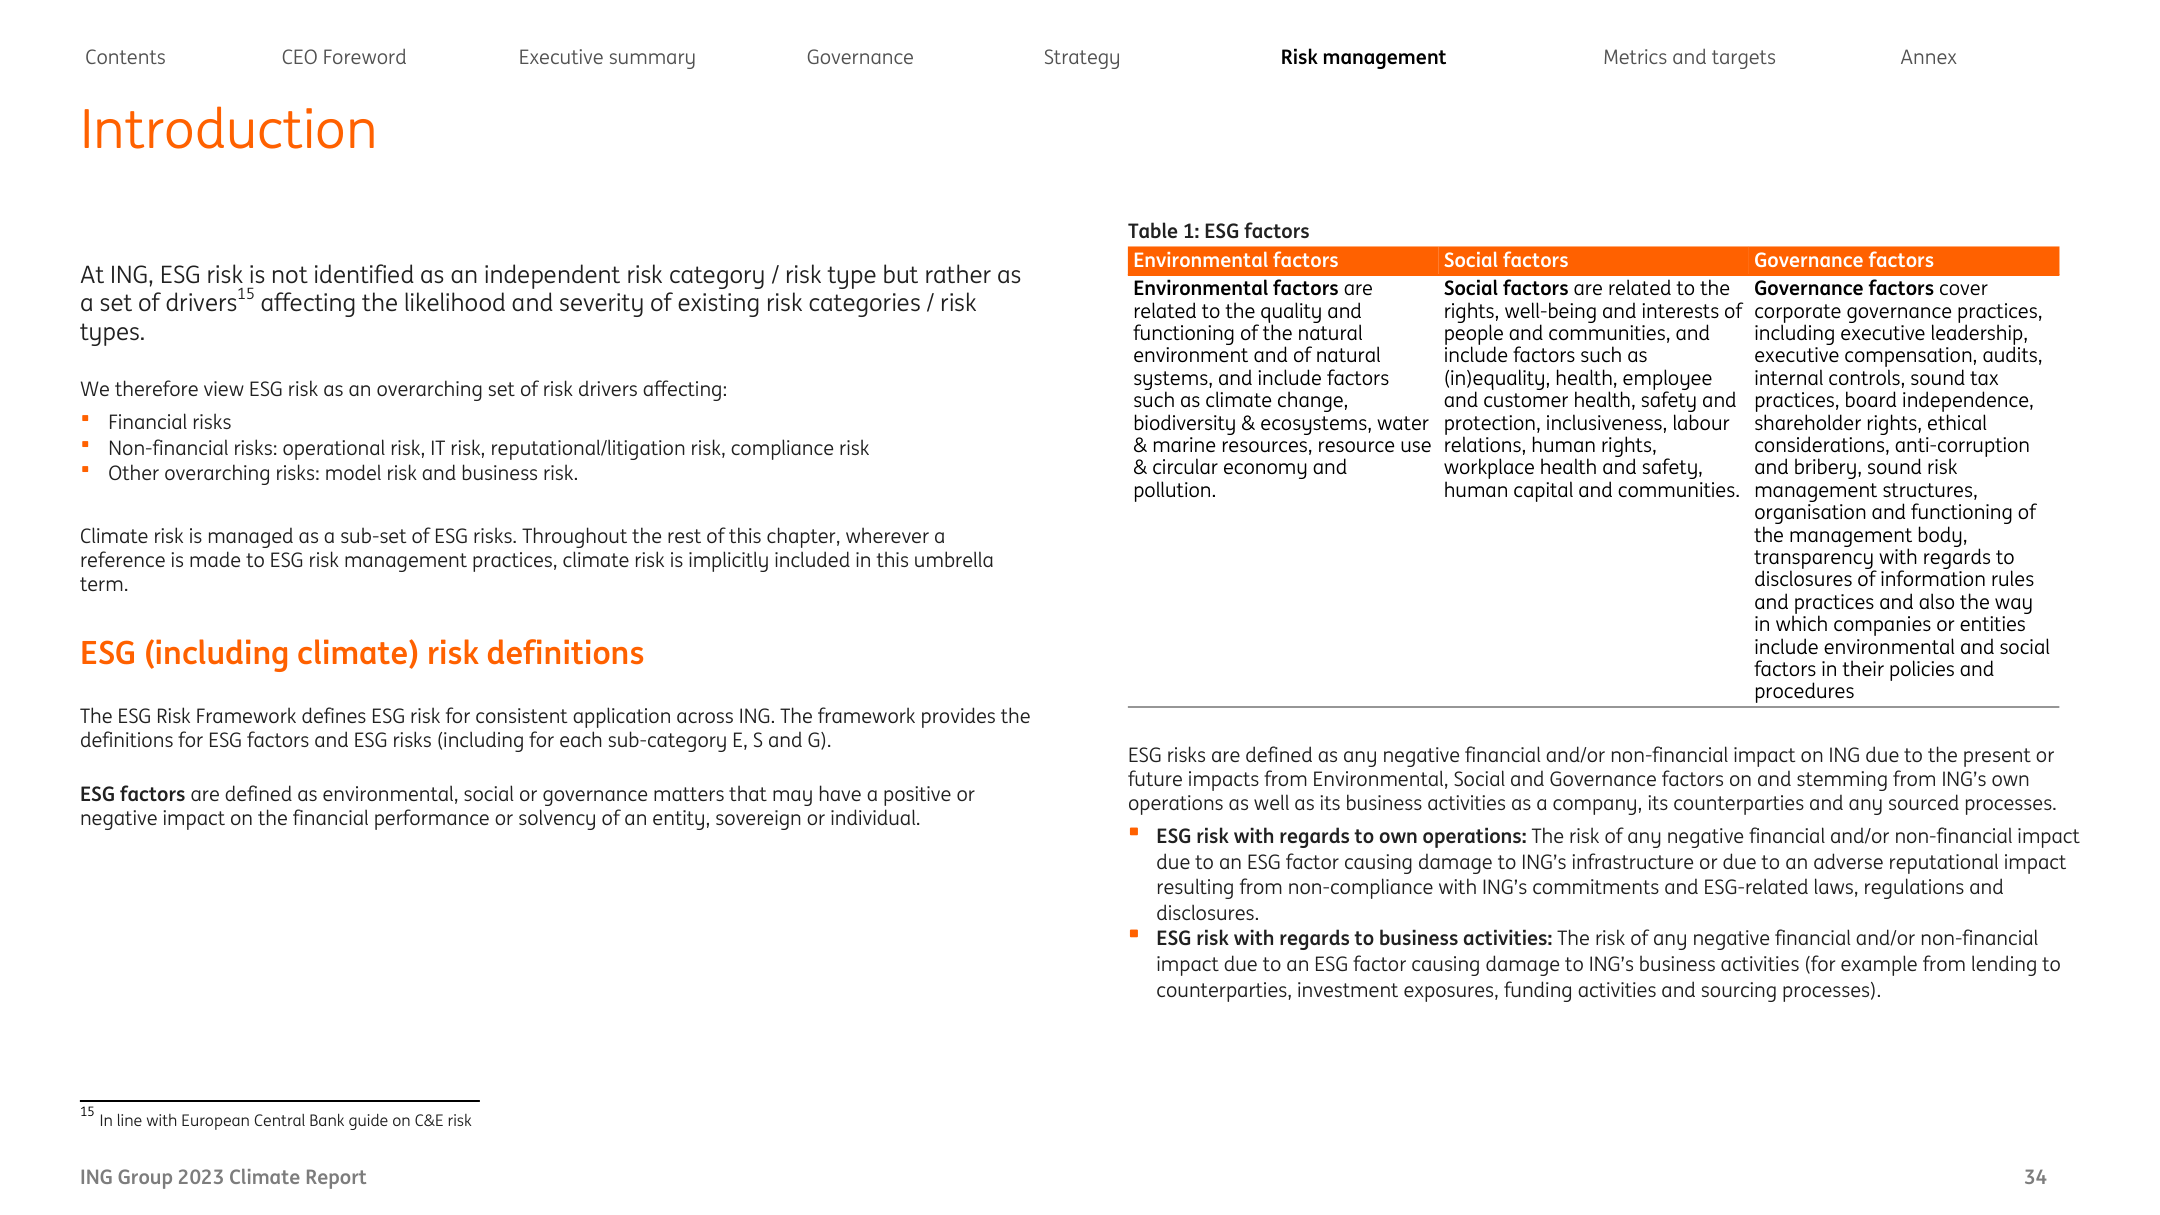

In [151]:
pdf = fitz.open('Data\\2023_Climate-Report-ING-Groep-NV.pdf')
p43 = pdf.load_page(33)
pix = p43.get_pixmap(matrix=fitz.Matrix(2,2))

image = Image.open(io.BytesIO(pix.tobytes("png")))
image

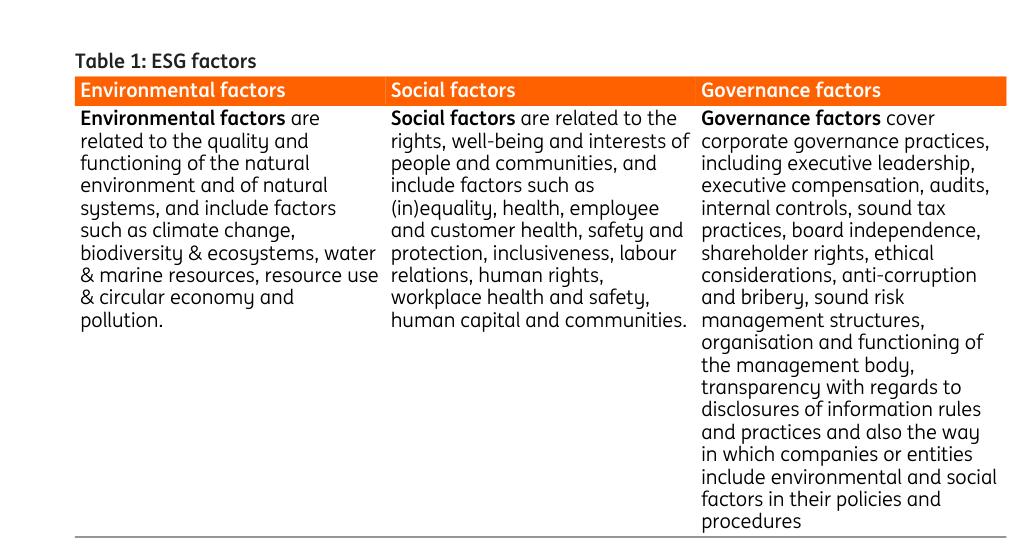

In [153]:
detection_results = pipe(image)
confidence, _, box = detection_results[0].values() 

d = 20
# cropped_image = image.crop((box['xmin']*0.9,
#                             box['ymin']*0.9,
#                             box['xmax']*1.02,
#                             box['ymax']*1.02))

cropped_image = image.crop((box['xmin']-d, 
                            box['ymin']-3.5*d, 
                            box['xmax']+2*d,
                            box['ymax']+d))
cropped_image

In [32]:
system_prompt = """
You are an expert data extraction assistant. Your task is to extract tabular data from images of tables and convert them precisely and accurately into CSV format, using commas as delimiters.

Your output must only contain the CSV text, without any explanations, headers, labels, or formatting beyond the CSV content itself. Do not include quotes around values unless the value itself contains a comma.

When interpreting the table:

- Accurately preserve the row and column structure.

- Do NOT assume any column (including the first) is an index column. All visible columns must be included with proper headers. If a header is missing, use generic ones like "Column1", "Column2", etc.

- If the table contains a unit of measurement declared above or between sections (e.g., "km/h", "USD", "tons CO₂"), append the unit in parentheses to the applicable row or column label. For example: "Speed (km/h)" or "Car (km/h)". This applies to units that are clearly associated with the values that follow.

- Choose the most logical and readable representation for the CSV output if the table is ambiguous.

- Merge or split cells only if necessary to preserve meaning and alignment.

- Do not invent or hallucinate values. If a cell is empty or unclear, represent it as an empty field.

- Ensure consistent row lengths in the final CSV output.

- Maintain numeric and textual fidelity: do not alter units, decimal places, or textual content.

Output only the raw CSV, no preamble, no code blocks, no markdown, no extra commentary—just the CSV text.
"""

In [ ]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

# Path to your image
image_path = "Data\\ING Report\\pg_44_table_2.jpg"

# Getting the base64 string
base64_image = encode_image(image_path)

client = Groq(api_key="GET_YOUR_OWN_ITS_FREE 😉")


chat_completion = client.chat.completions.create(
    messages=[
        {
          "role" : "system",
          "content" : system_prompt          
        },

        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Convert the contents of the image into a CSV format."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}",
                    },
                },
            ],
        }
    ],
    model="meta-llama/llama-4-scout-17b-16e-instruct",
)

print(chat_completion.choices[0].message.content)

"Scope 2 (including extrapolations)","2022","2021","2020","2014"
"Coverage (% of employees)","98","98","97","91"
"Electricity (Kilotonne CO₂e)","0.5","0.5","0.1","46.6"
"District heating (Kilotonne CO₂e)","9","9","8","7"


In [41]:
pd.read_csv(StringIO(chat_completion.choices[0].message.content),
            sep=",",)

,Scope 2 (including extrapolations),2022,2021,2020,2014
0,Coverage (% of employees),98.0,98.0,97.0,91.0
1,Electricity (Kilotonne CO₂e),0.5,0.5,0.1,46.6
2,District heating (Kilotonne CO₂e),9.0,9.0,8.0,7.0
